# Kaggle Import Data

In [1]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()

Kaggle credentials set.
Kaggle credentials successfully validated.


In [2]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

deep_learning_spring_2025_project_1_path = kagglehub.competition_download('deep-learning-spring-2025-project-1')

print('Data source import complete.')

100%|██████████| 189M/189M [00:01<00:00, 104MB/s]

Extracting files...


Data source import complete.


In [3]:
print(deep_learning_spring_2025_project_1_path)

/root/.cache/kagglehub/competitions/deep-learning-spring-2025-project-1


# CIFAR-10 Classification using WideResNet
This notebook loads CIFAR-10 data, preprocesses it, defines a WideResNet model, trains it, and evaluates performance.

In [4]:

import numpy as np
import os
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchsummary import summary
import matplotlib.pyplot as plt
import seaborn as sns

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


## Load CIFAR-10 Data

In [5]:

# Load CIFAR-10 data
def load_cifar_batch(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

cifar10_dir = '/root/.cache/kagglehub/competitions/deep-learning-spring-2025-project-1/cifar-10-python/cifar-10-batches-py'
meta_data_dict = load_cifar_batch(os.path.join(cifar10_dir, 'batches.meta'))
label_names = [label.decode('utf-8') for label in meta_data_dict[b'label_names']]
print("Class Labels:", label_names)


Class Labels: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


## Data Preprocessing and Augmentation

In [6]:

# Load and preprocess training data
train_data, train_labels = [], []
for i in range(1, 6):
    batch = load_cifar_batch(os.path.join(cifar10_dir, f'data_batch_{i}'))
    train_data.append(batch[b'data'])
    train_labels += batch[b'labels']
train_data = np.vstack(train_data).reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
train_labels = np.array(train_labels)

# Define transformations
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomCrop(32, padding=4),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.1), value=1.0, inplace=False)
])

# Define dataset class
class CustomCIFAR10Dataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, label


## Load Training and Validation Datasets

In [7]:

# Load datasets
train_dataset = CustomCIFAR10Dataset(train_data, train_labels, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True, num_workers=4)

batch_test_dict = load_cifar_batch(os.path.join(cifar10_dir, 'test_batch'))
val_images = batch_test_dict[b'data'].reshape(-1, 3, 32, 32).transpose(0, 2, 3, 1)
val_labels = np.array(batch_test_dict[b'labels'])
val_dataset = CustomCIFAR10Dataset(val_images, val_labels, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False, num_workers=4)


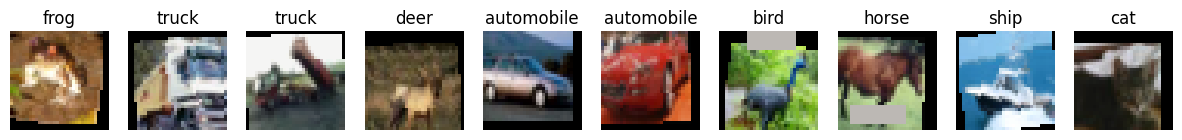

In [8]:
# Function to plot sample images from dataset
def plot_sample_images(dataset, label_names, num_images=10):
    # Define the mean and std used for normalization
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.247, 0.243, 0.261])

    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        img, label = dataset[i]
        # Denormalize the image
        img = img.permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)
        img = std * img + mean  # Denormalize
        img = np.clip(img, 0, 1)  # Clip values to be in the range [0, 1]
        axes[i].imshow(img)
        axes[i].set_title(label_names[label])
        axes[i].axis('off')
    plt.show()

plot_sample_images(train_dataset, label_names, num_images=10)

## Define Custom ResNet Model

In [9]:

# Define WideResNet model
class ResNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResNetBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.skip = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.skip = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = self.skip(x) if self.skip else x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu(out)
        return out

class ResNet22_4_Modified(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet22_4_Modified, self).__init__()
        self.init_conv = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1, bias=False)
        self.init_bn = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(32, 64, 3, stride=1)
        self.layer2 = self._make_layer(64, 128, 3, stride=2)
        self.layer3 = self._make_layer(128, 256, 3, stride=2)
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(256, num_classes)

    def _make_layer(self, in_channels, out_channels, blocks, stride):
        layers = [ResNetBlock(in_channels, out_channels, stride)]
        for _ in range(1, blocks):
            layers.append(ResNetBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.init_conv(x)
        out = self.init_bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = torch.flatten(out, 1)
        out = self.fc(out)
        return out

# Initialize model
model = ResNet22_4_Modified().to(device)
summary(model, (3, 32, 32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
       BatchNorm2d-2           [-1, 32, 32, 32]              64
              ReLU-3           [-1, 32, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]           2,048
       BatchNorm2d-5           [-1, 64, 32, 32]             128
            Conv2d-6           [-1, 64, 32, 32]          18,432
       BatchNorm2d-7           [-1, 64, 32, 32]             128
              ReLU-8           [-1, 64, 32, 32]               0
            Conv2d-9           [-1, 64, 32, 32]          36,864
      BatchNorm2d-10           [-1, 64, 32, 32]             128
             ReLU-11           [-1, 64, 32, 32]               0
      ResNetBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13           [-1, 64, 32, 32]          36,864
      BatchNorm2d-14           [-1, 64,

In [10]:
def train_model(model, train_loader, val_loader, epochs=50, patience=10, min_delta=0.001):
    criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=5e-4)
    scheduler = CosineAnnealingLR(optimizer, T_max=epochs)

    best_val_loss = float('inf')
    epochs_no_improve = 0

    # Initialize history dictionary
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    for epoch in range(epochs):
        model.train()
        train_loss, correct_train, total_train = 0, 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            _, predicted = outputs.max(1)
            correct_train += predicted.eq(labels).sum().item()
            total_train += labels.size(0)

        # Calculate training accuracy
        train_accuracy = 100 * correct_train / total_train

        # Validation phase
        model.eval()
        val_loss, correct_val, total_val = 0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = outputs.max(1)
                correct_val += predicted.eq(labels).sum().item()
                total_val += labels.size(0)

        # Calculate validation accuracy
        val_accuracy = 100 * correct_val / total_val
        val_loss /= len(val_loader)  # Average the validation loss

        scheduler.step()

        # Append metrics to history
        history['train_loss'].append(train_loss / len(train_loader))
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_accuracy)
        history['val_acc'].append(val_accuracy)

        print(f"Epoch {epoch+1}:")
        print(f"    Train Loss: {train_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.2f}%")
        print(f"    Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

        # Early stopping check
        if val_loss < best_val_loss - min_delta:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    return history

In [11]:
training_history = train_model(model, train_loader, val_loader, epochs=100, patience=10, min_delta=0.001)

Epoch 1:
    Train Loss: 2.1651, Train Accuracy: 25.66%
    Val Loss: 1.9489, Val Accuracy: 31.15%
Epoch 2:
    Train Loss: 1.7250, Train Accuracy: 42.08%
    Val Loss: 1.6794, Val Accuracy: 45.61%
Epoch 3:
    Train Loss: 1.5327, Train Accuracy: 52.22%
    Val Loss: 1.5210, Val Accuracy: 53.36%
Epoch 4:
    Train Loss: 1.3847, Train Accuracy: 59.92%
    Val Loss: 1.4621, Val Accuracy: 56.88%
Epoch 5:
    Train Loss: 1.2764, Train Accuracy: 65.23%
    Val Loss: 1.4181, Val Accuracy: 57.33%
Epoch 6:
    Train Loss: 1.2047, Train Accuracy: 68.56%
    Val Loss: 1.2970, Val Accuracy: 64.95%
Epoch 7:
    Train Loss: 1.1366, Train Accuracy: 71.86%
    Val Loss: 1.2005, Val Accuracy: 69.32%
Epoch 8:
    Train Loss: 1.0658, Train Accuracy: 75.16%
    Val Loss: 1.1670, Val Accuracy: 69.95%
Epoch 9:
    Train Loss: 1.0143, Train Accuracy: 77.66%
    Val Loss: 1.0885, Val Accuracy: 74.04%
Epoch 10:
    Train Loss: 0.9791, Train Accuracy: 79.29%
    Val Loss: 1.1070, Val Accuracy: 72.91%
Epoch 11:

In [ ]:

# Function to plot training & validation loss/accuracy
def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Accuracy')
    plt.plot(epochs, history['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training & Validation Accuracy')
    plt.legend()

    plt.show()

plot_training_history(training_history)

NameError: name 'training_history' is not defined

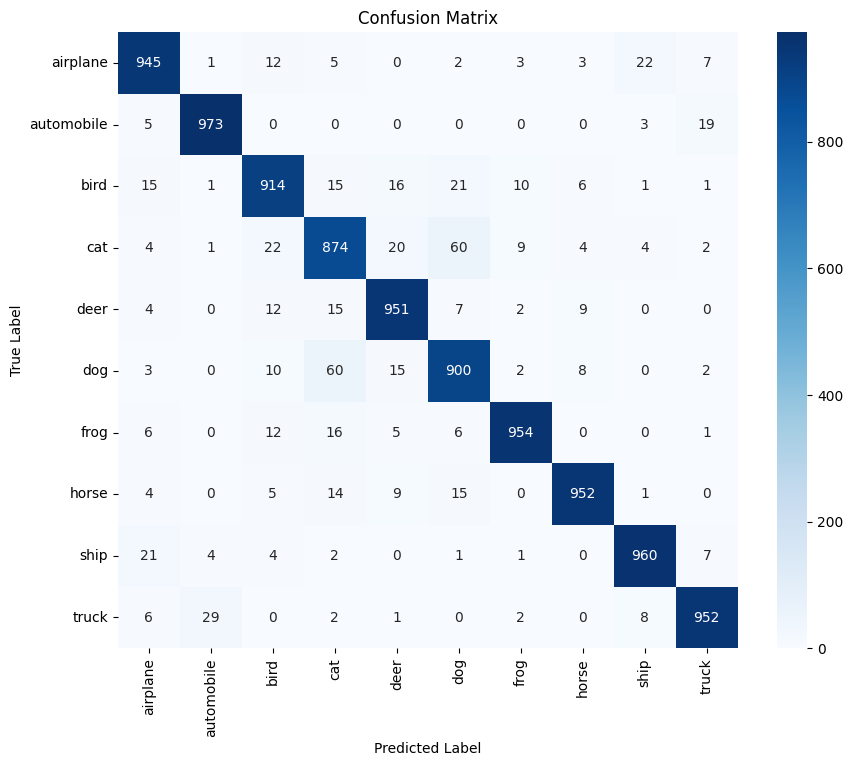

In [13]:
from sklearn.metrics import confusion_matrix

# Function to plot confusion matrix
def plot_confusion_matrix(model, dataloader, label_names):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

plot_confusion_matrix(model, val_loader, label_names)

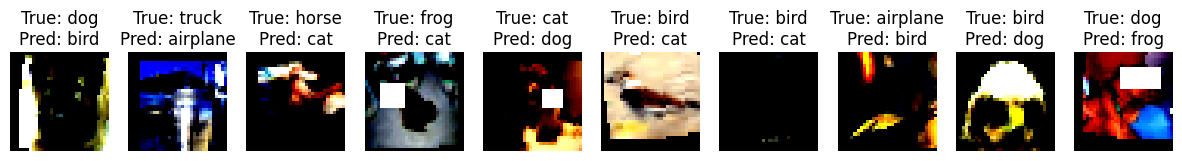

In [14]:
# Function to show misclassified images
def plot_misclassified_images(model, dataset, num_images=10):
    model.eval()
    misclassified = []
    with torch.no_grad():
        for i in range(len(dataset)):
            img, label = dataset[i]
            img_tensor = img.unsqueeze(0).to(device)
            output = model(img_tensor)
            _, predicted = torch.max(output, 1)
            if predicted.item() != label:
                misclassified.append((img, label, predicted.item()))
            if len(misclassified) == num_images:
                break

    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i, (img, true_label, pred_label) in enumerate(misclassified):
        img = img.permute(1, 2, 0).numpy()
        axes[i].imshow(img)
        axes[i].set_title(f'True: {label_names[true_label]}\nPred: {label_names[pred_label]}')
        axes[i].axis('off')
    plt.show()

plot_misclassified_images(model, val_dataset, num_images=10)

In [15]:
test_transform = transforms.Compose([
    transforms.ToPILImage(),  # Convert numpy array to PIL Image
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
])

# Load test dataset
cifar_test_path = '/root/.cache/kagglehub/competitions/deep-learning-spring-2025-project-1/cifar_test_nolabel.pkl'
test_batch = load_cifar_batch(cifar_test_path)
test_images = test_batch[b'data'].astype(np.float32) / 255.0

# Convert test dataset to Tensor
test_dataset = [(test_transform(img),) for img in test_images]
test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False, num_workers=4)

In [16]:
import pandas as pd

model.eval()
predictions7 = []
with torch.no_grad():
    for batch in test_loader:
        images = batch[0].to(device)  # Get images tensor from tuple and move to device
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        predictions7.extend(predicted.cpu().numpy())

# Generate submission file
submission = pd.DataFrame({'ID': np.arange(len(predictions7)), 'Labels': predictions7})
submission.to_csv('submission.csv', index=False)
print("Submission file saved.")

Submission file saved.


In [18]:
from google.colab import files
files.download('submission.csv')
torch.save(model.state_dict(), "model_weights.pth")
files.download('model_weights.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<ipython-input-19-d6cd46d3d7c1>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=predictions7, palette="viridis")


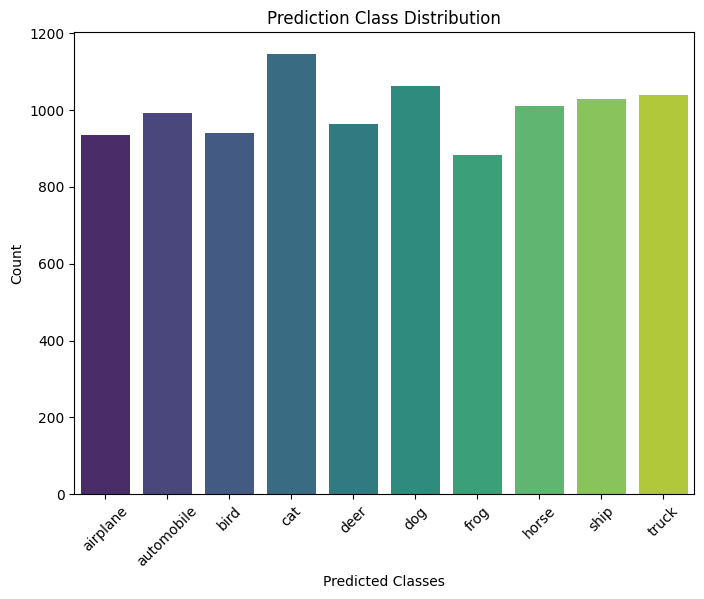

In [19]:
plt.figure(figsize=(8, 6))
sns.countplot(x=predictions7, palette="viridis")
plt.xticks(ticks=np.arange(len(label_names)), labels=label_names, rotation=45)
plt.xlabel('Predicted Classes')
plt.ylabel('Count')
plt.title('Prediction Class Distribution')
plt.show()